In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from skimage import feature
from pylab import *
import struct
import mrcfile
import math
import sys

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

import hyperspy.api as hs
from hyperspy import io_plugins
from PIL import Image
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [28]:
with mrcfile.open('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210522/GSNoCDS3/GSNoCDS3_Top_16-18-37.889_integratedframes.mrc') as mrc:
    data = mrc.data

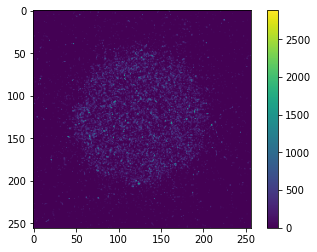

In [37]:
plt.imshow(data[64,:,:])
plt.colorbar()

In [4]:
ExpPath = '/srv/home/voyles/home-chenyu/DEbackup/2019/061219/S8/npy/'
RefPath = '/srv/home/voyles/home-chenyu/DEbackup/2019/061219/S0/npy/'
ExpName = 'S8'
RefName = 'S0'
rx = 100;
ry = 100;

230.80190919025063 259.8529640780329


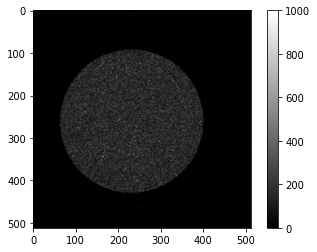

In [5]:
sample = np.load(RefPath+RefName+'_'+format(64,'05')+'.npy')
#sample = data[5,:,:]
kx,ky = sample.shape[0:2]
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

COM_x = np.average(weights_x,weights = sample)
COM_y = np.average(weights_y,weights = sample)
           
#plt.imshow(log(sample))
plt.imshow(sample, vmin=0, vmax=1000,cmap = 'gray')
plt.colorbar()
#plt.scatter(COM_x,COM_y)
print(COM_x,COM_y)

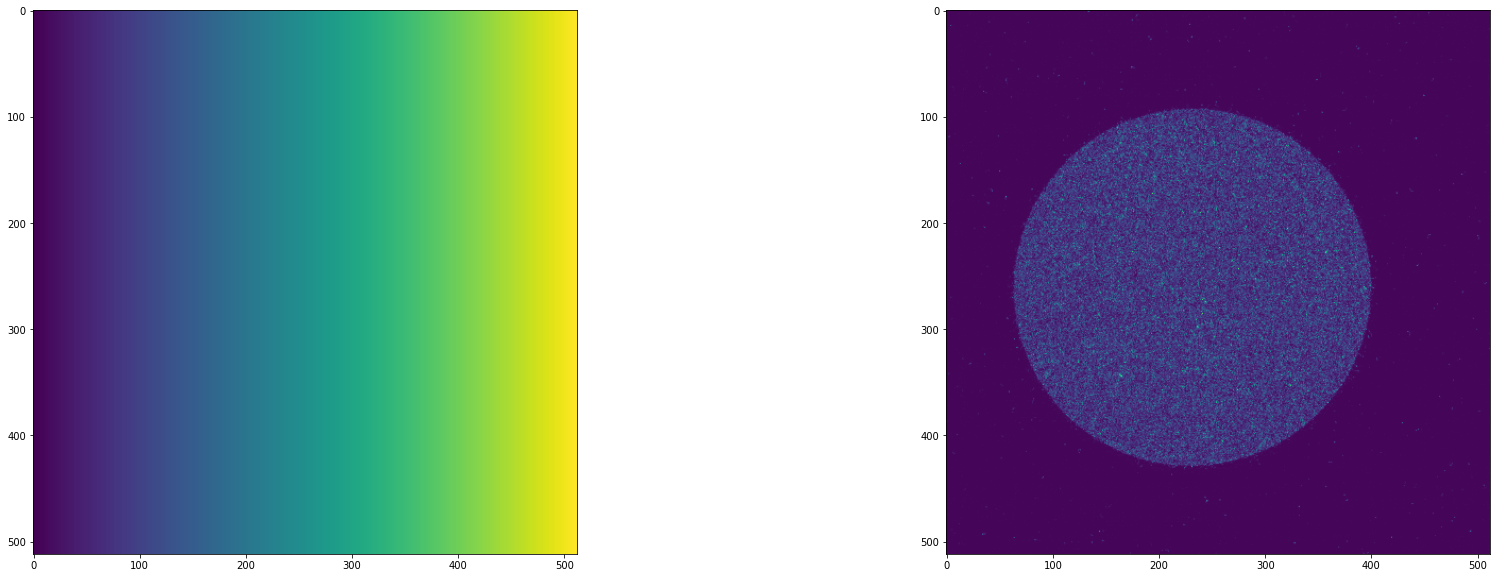

In [6]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot(121)
plt.imshow(weights_x)
fig.add_subplot(122)
plt.imshow(sample)

In [7]:
num_rows = 150
num_cols = 150

sample = np.load(RefPath+RefName+'_'+format(1,'05')+'.npy') # used for old method
kx,ky = sample.shape[0:2] # used for old method
#kx, ky = data.shape[1:] # new
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

COM = np.zeros((num_rows,num_cols,2))

for irow in range(num_rows):
    for icol in range(num_cols):
        nSample = irow*num_cols+icol+1 #
        sample = np.load(RefPath+RefName+'_'+format(nSample,'05')+'.npy') # 
        #nSample = irow*num_cols+icol #new
        #sample = data[nSample,:,:]   #new
        COM[irow,icol,0] = np.average(weights_x,weights = sample)
        COM[irow,icol,1] = np.average(weights_y,weights = sample)
        
        if irow % 10 == 0 and icol == 0:
            print("Finished row %d " % (irow))
            

Finished row 0 
Finished row 10 
Finished row 20 
Finished row 30 


KeyboardInterrupt: 

In [170]:
np.save('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210522/GSNoCDS3_200X200/BlankCOM.npy',COM)
print(np.mean(COM[:,:,0]))
print(np.mean(COM[:,:,1]))

126.32220124210588
126.3490472753827


**The last value in COM is empty because there is only 2499 frames.**

## next part

In [78]:
def gaussian(height, center_x, center_y, width_x, width_y):

    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)
 
def moments(data):

    total = data.sum()
    X, Y = indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = sqrt(abs((arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = sqrt(abs((arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y
 
def fitgaussian(data):

    params = moments(data)
    errorfunction = lambda p: ravel(gaussian(*p)(*indices(data.shape)) -
                                  data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [79]:
# test
kx = 1024
ky = 1024
kx2,ky2 = np.meshgrid(np.linspace(0,kx-1,kx), np.linspace(0,ky-1,ky))
distance_from_center = np.sqrt((kx2 - 512)**2 + (ky2-512)**2)
mask = distance_from_center <= 200
mask = mask* distance_from_center
mask_FT = np.fft.fft2(mask)

frame = sample
frame = frame/frame.max()
fitrange = 200
frame = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(frame) * mask_FT)).real
frame_crop = frame[int(COM_y)-fitrange:int(COM_y)+fitrange,int(COM_x)-fitrange:int(COM_x)+fitrange]
params = fitgaussian(frame_crop)
plt.imshow(sample)
plt.scatter(params[1]+COM_x-fitrange,params[2]+COM_y-fitrange)
print(params[1]+COM_x-fitrange,params[2]+COM_y-fitrange)

ValueError: operands could not be broadcast together with shapes (512,512) (1024,1024) 

In [382]:
rx = 100
ry = 100
kx = 1024
ky = 1024
kx2,ky2 = np.meshgrid(np.linspace(0,kx-1,kx), np.linspace(0,ky-1,ky))
distance_from_center = np.sqrt((kx2 - 512)**2 + (ky2-512)**2)
mask = distance_from_center <= 200
mask = mask* distance_from_center
mask_FT = np.fft.fft2(mask)
pos = np.zeros((rx,ry,2))

COM = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/counting/1900FPS/BlankCOM.npy')

for ix in range(rx):
    for iy in range(ry):
        COM_x = COM[ix,iy,0]
        COM_y = COM[ix,iy,1]
        #filenum = ix*rx+iy+1
        #frame = np.load(RefPath+RefName+'_'+format(filenum,'05')+'.npy')
        filenum = ix*rx+iy
        frame = data[filenum,:,:]
        frame = frame/frame.max()
        frame = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(frame) * mask_FT)).real
        frame_crop = frame[int(COM_y)-200:int(COM_y)+200,int(COM_x)-200:int(COM_x)+200] #150
        params = fitgaussian(frame_crop)
        
#         print(params[1],params[2])
        
        pos[ix,iy,0] = params[1]+COM_x-200 # xpos
        pos[ix,iy,1] = params[2]+COM_y-200 # ypos
        
        if ix % 10 == 0 and iy == 0:
            print("Finished line %d " % (ix))

Finished line 0 


KeyboardInterrupt: 

In [456]:
np.save('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/counting/24000FPS/BlankCOMpos.npy',pos)

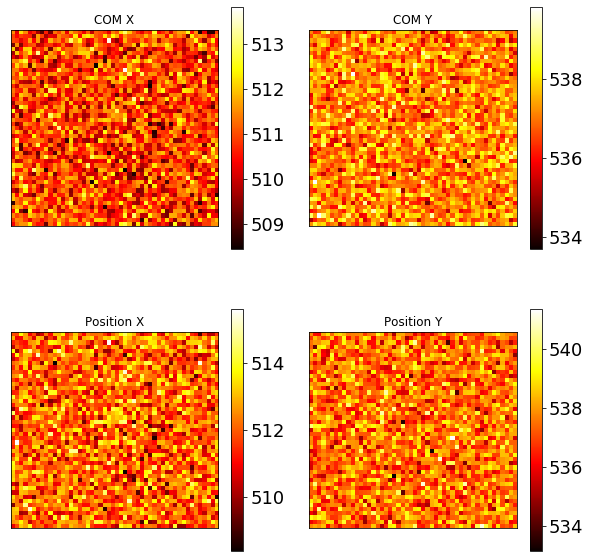

In [81]:
COM = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/threshold/BlankCOM.npy')
pos = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/threshold/BlankCOMpos.npy')

f, axarr = plt.subplots(2, 2, gridspec_kw = {'wspace':0.15, 'hspace':0.25}, figsize=(10,10))

im = axarr[0,0].imshow(COM[2:-1,:,0],cmap='hot')
axarr[0,0].set_xticks([])
axarr[0,0].set_yticks([])
axarr[0,0].set_title('COM X')
cbar=f.colorbar(im,ax=axarr[0,0])
cbar.ax.tick_params(labelsize=18)

im = axarr[0,1].imshow(COM[2:-1,:,1],cmap='hot')
axarr[0,1].set_xticks([])
axarr[0,1].set_yticks([])
axarr[0,1].set_title('COM Y')
cbar = f.colorbar(im, ax=axarr[0,1])
cbar.ax.tick_params(labelsize=18) 

# Seems X and Y are reversed in position fitting

im = axarr[1,0].imshow(pos[2:-1,:,0],cmap='hot')
axarr[1,0].set_xticks([])
axarr[1,0].set_yticks([])
axarr[1,0].set_title('Position X')
cbar = f.colorbar(im, ax=axarr[1,0])
cbar.ax.tick_params(labelsize=18) 

im = axarr[1,1].imshow(pos[2:-1,:,1],cmap='hot')
axarr[1,1].set_xticks([])
axarr[1,1].set_yticks([])
axarr[1,1].set_title('Position Y')
cbar = f.colorbar(im, ax=axarr[1,1])
cbar.ax.tick_params(labelsize=18)

## Analysis zerodisk shift in blank scan using Hough transform

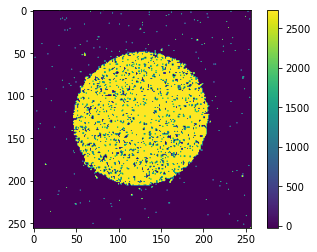

In [160]:
sample = np.load(RefPath+RefName+'_'+format(2500,'05')+'.npy')
#sample = data[18,:,:]
plt.imshow(sample)
plt.colorbar()
bw = 1.0*(sample > 12)
plt.imshow(bw)
selem = disk(3)
bw2 = closing(bw, selem)
plt.imshow(bw2)
edges = feature.canny(bw2)
plt.imshow(bw)

[125 126 128] [128 128 129] [78 79 81]
126 128 79


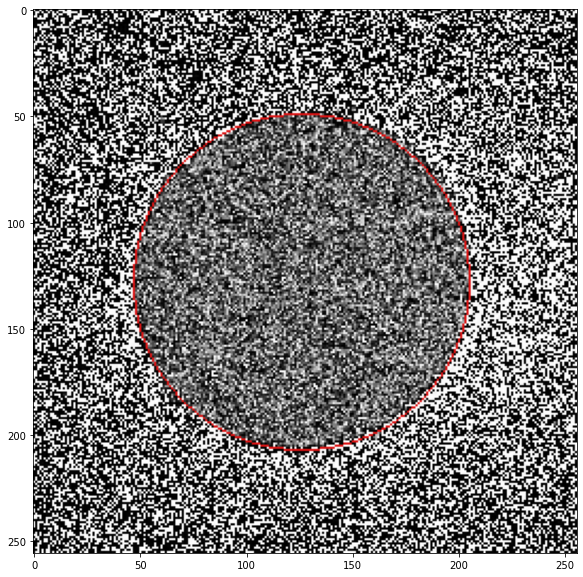

cx axis1: 126 cy axis2: 128 radius: 79


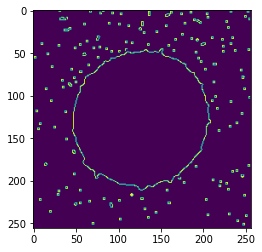

In [161]:
bw = 1.0*(sample > 12)
selem = disk(3)
bw2 = closing(bw, selem)
edges = feature.canny(bw2)

#sample = sample*bw*1000000
sample = sample.astype('uint8')
temp = edges.astype('uint8')
# plt.imshow(sample)
# plt.colorbar()

image = sample

# Detect two radii
hough_radii = np.arange(50,120,1)
hough_res = hough_circle(temp, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

print(cx,cy,radii)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)
# circy, circx = circle_perimeter(290,262,181)
image[circy, circx] = (220, 20, 20)

# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = circle_perimeter(center_y, center_x, radius)
#     image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(temp)
print('cx axis1:', cx,'cy axis2:',cy,'radius:',radii)

## BF, ABF, COM, PACBED reconstruction from experiment dataset

In [2]:
with mrcfile.open('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/counting/Blank24000fps_countedframes.mrc') as mrc:
    expdata = mrc.data

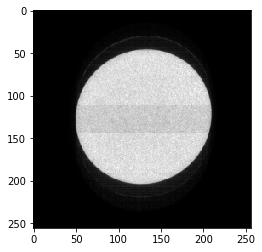

In [5]:
stack = np.zeros(expdata.shape[1:])
for i in range(17,expdata.shape[0]):
    stack = stack + expdata[i,:,:]
plt.imshow(stack)

1024X1024Readout CL160:

ABF_radius = 162  BF_radius = 324 or 326 ADF_radius = 426 or 429

512X512Readout CL77:

ABF_radius = 79  BF_radius = 158  ADF_radius = 208

256X256Readout CL38:

ABF_radius = 41  BF_radius = 82  ADF_radius = 108


In [15]:
from SeqIO import load_celeritas
path = '/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210621/49000fpsA50um/'

expdata = load_celeritas(
    path+'Movie_00034_Top_14-15-45.386.seq',
    path+'Movie_00034_Bottom_14-15-45.415.seq',
    dark=path+'Movie_00034.seq.dark.mrc',
    gain=path+'Movie_00034.seq.gain.mrc',
    metadata=None,
    xml_file=path+'Movie_00034.seq.Config.Metadata.xml',
    lazy=False,
    chunks=None,
    nav_shape=(512,512),
    parameters=None,
)

The prebuffer:  123
The Image Height:  64
66
Grouping Bytes:  4038656


try with seqio and counting filter

frame 0 cannot be counted

In [37]:
from scipy.ndimage import label
from scipy.ndimage import center_of_mass

def counting_filter3(image, threshold=5):
    image_binary = image > threshold  # more readable
    all_labels, num = label(image_binary)  # get blobs
    obj = center_of_mass(image, all_labels, range(num))
    obj = np.rint(obj).astype(int)
    x = np.zeros(shape=np.shape(image))
    x[obj[:,0],obj[:,1]]=1
    return x

In [96]:
rx = 150
ry = 150
kx = 512 
ky = 512 #256
PACBED = np.zeros((kx,ky))
#Data_4D = np.zeros((100,100,512,512),dtype = int)
COM = np.load('/srv/home/voyles/home-chenyu/DEbackup/2019/061219/BlankCOM.npy')##############

kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky) #swaped
kx2,ky2 = np.meshgrid(kx,ky)## swaped

COM_exp = np.zeros((rx,ry,2))
COM_exp_ang = np.zeros((rx,ry))
BF = np.zeros((rx,ry))
ABF = np.zeros((rx,ry))
LBF = np.zeros((rx,ry))
ADF = np.zeros((rx,ry))

# inner collection radius for ABF and outer collection radius for BF/ABF, replace with Hough detected radius later
ABF_radius = 41
BF_radius = 82
ADF_radius = 108

for ix in range(rx):
    for iy in range(ry):

        center_x = COM[ix+1,iy,0]
        center_y = COM[ix+1,iy,1]
        
        frame = expdata.data[ix,iy,:,int(center_x-64):int(center_x+64)]
        frame[frame<7] = 0
        #framec = counting_filter3(frame)
        #resized = cv2.resize(frame,(512,512),interpolation = cv2.INTER_AREA)
        #Data_4D[ix,iy,:,:] = frame.astype('int')
        COM_exp[ix,iy,0] = np.average(weights_x,weights = frame)
        COM_exp[ix,iy,1] = np.average(weights_y,weights = frame)
        COM_exp_ang[ix,iy] = math.atan2(COM_exp[ix,iy,0]-COM[ix,iy,0],COM_exp[ix,iy,1]-COM[ix,iy,1])
        

        distance_from_center = np.sqrt((kx2 - center_x)**2 + (ky2-center_y)**2)
        ADF_mask = (distance_from_center > (BF_radius+20)) & (distance_from_center <= (ADF_radius+20))
        ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
        BF_mask = distance_from_center <= BF_radius
        
        BF[ix,iy] = (frame*BF_mask).sum()
        ABF[ix,iy] = (frame*ABF_mask).sum()
        #ADF[ix,iy] = (frame*ADF_mask).sum()
        PACBED = PACBED + frame
        
        
#np.save(ExpPath + 'ADF.npy',ADF)
#np.save(ExpPath + 'Data_4D_128px_int.npy',Data_4D)
# np.save(ExpPath+'COM.npy',COM_exp)
# np.save(ExpPath+'BF.npy',BF)
# np.save(ExpPath+'ABF.npy',ABF)
# np.save(ExpPath+'PACBED.npy',PACBED)

IndexError: index 512 is out of bounds for axis 0 with size 512

In [14]:
rx = 150
ry = 150
kx = 512 
ky = 512
ExpPath = '/srv/home/voyles/home-chenyu/DEbackup/2019/061219/S8/'
COM = np.load('/srv/home/voyles/home-chenyu/DEbackup/2019/061219/BlankCOM.npy')##############

PACBED = np.zeros((kx,ky))
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
kx2,ky2 = np.meshgrid(kx,ky)

COM_exp = np.zeros((rx,ry,2))
COM_exp_ang = np.zeros((rx,ry))
LBF = np.zeros((rx,ry))
ABF = np.zeros((rx,ry))
ADF = np.zeros((rx,ry))

# inner collection radius for ABF and outer collection radius for BF/ABF, replace with Hough detected radius later
ABF_radius = 83
BF_radius = 167
ADF_radius = 276

for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(ExpPath+'npy/'+ExpName+'_'+format(filenum,'05')+'.npy')
        COM_exp[ix,iy,0] = np.average(weights_x,weights = frame)
        COM_exp[ix,iy,1] = np.average(weights_y,weights = frame)
        COM_exp_ang[ix,iy] = math.atan2(COM_exp[ix,iy,0]-COM[ix,iy,0],COM_exp[ix,iy,1]-COM[ix,iy,1])
        
        center_x = COM[ix,iy,0]
        center_y = COM[ix,iy,1]
        distance_from_center = np.sqrt((kx2 - center_x)**2 + (ky2-center_y)**2)
        ADF_mask = (distance_from_center > BF_radius) & (distance_from_center <= ADF_radius)
        ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
        LBF_mask = distance_from_center <= (BF_radius/2)
        
        LBF[ix,iy] = (frame*LBF_mask).sum()
        ABF[ix,iy] = (frame*ABF_mask).sum()
        #ADF[ix,iy] = (frame*ADF_mask).sum()
        #PACBED = PACBED + frame
        
COM_exp = COM_exp - COM
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)

np.save(ExpPath + 'LBF.npy',LBF)
#np.save(ExpPath + 'Data_4D_128px_int.npy',Data_4D)
# np.save(ExpPath+'COM.npy',COM_exp)
# np.save(ExpPath+'BF.npy',BF)
# np.save(ExpPath+'ABF.npy',ABF)
# np.save(ExpPath+'PACBED.npy',PACBED)

In [90]:
# the pixel that hit 
ec = (frame > 2).sum()
ec/128/128

0.296630859375

In [15]:
COM_exp = COM_exp - COM
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)

Text(0.5, 1.0, 'COM magnitute')

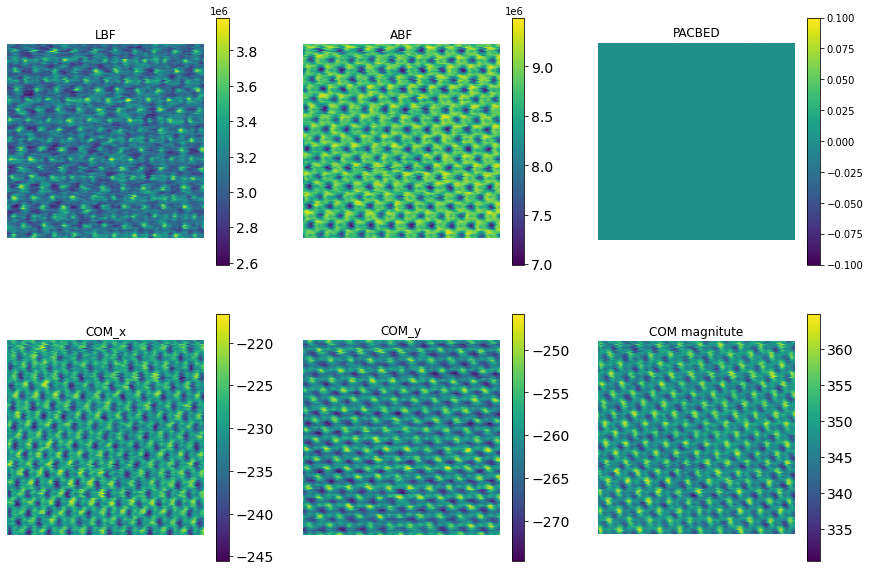

In [16]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(2,3,1)
plt.imshow(LBF[1:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('LBF')

fig.add_subplot(2,3,2)
plt.imshow(ABF[1:-1:,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('ABF')

fig.add_subplot(2,3,3)
plt.imshow(PACBED[1:-1,1:-1])
cbar = plt.colorbar()
plt.axis('off')
plt.title('PACBED')

fig.add_subplot(2,3,4)
plt.imshow(COM_exp[1:-1,:,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_x')

fig.add_subplot(2,3,5)
plt.imshow(COM_exp[1:-1:,:,1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_y')

fig.add_subplot(2,3,6)
plt.imshow(COM_exp_mag[2:-1,:])
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.title('COM magnitute')

In [12]:
rx = 100
ry = 100
kx = 512
ky = 512
PACBED = np.zeros((kx,ky))
#Data_4D = np.zeros((100,100,512,512),dtype = int)
COM = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210522/RSCDS2/BlankCOM.npy')##############

kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
kx2,ky2 = np.meshgrid(kx,ky)

COM_exp = np.zeros((rx,ry,2))
COM_exp_ang = np.zeros((rx,ry))
BF = np.zeros((rx,ry))
ABF = np.zeros((rx,ry))
ADF = np.zeros((rx,ry))

# inner collection radius for ABF and outer collection radius for BF/ABF, replace with Hough detected radius later
ABF_radius = 79
BF_radius = 158
ADF_radius = 208

for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        #frame = np.load(ExpPath+ExpName+'_'+format(filenum,'05')+'.npy')
        ########
        # for pc = 2
        frame = (np.load(ExpPath+ExpName+'_'+format(filenum*2,'05')+'.npy') 
        + np.load(ExpPath+ExpName+'_'+format(filenum*2-1,'05')+'.npy'))/2
        
        ########
        #filenum = ix*rx+iy
        #frame = expdata[filenum,:,:]
        #resized = cv2.resize(frame,(512,512),interpolation = cv2.INTER_AREA)
        #Data_4D[ix,iy,:,:] = frame.astype('int')
        COM_exp[ix,iy,0] = np.average(weights_x,weights = frame)
        COM_exp[ix,iy,1] = np.average(weights_y,weights = frame)
        COM_exp_ang[ix,iy] = math.atan2(COM_exp[ix,iy,0]-COM[ix,iy,0],COM_exp[ix,iy,1]-COM[ix,iy,1])
        
        center_x = COM[ix,iy,0]
        center_y = COM[ix,iy,1]
        distance_from_center = np.sqrt((kx2 - center_x)**2 + (ky2-center_y)**2)
        ADF_mask = (distance_from_center > (BF_radius+20)) & (distance_from_center <= (ADF_radius+20))
        ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
        BF_mask = distance_from_center <= BF_radius
        
        BF[ix,iy] = (frame*BF_mask).sum()
        ABF[ix,iy] = (frame*ABF_mask).sum()
        ADF[ix,iy] = (frame*ADF_mask).sum()
        PACBED = PACBED + frame
        
#np.save(ExpPath + 'ADF.npy',ADF)
#np.save(ExpPath + 'Data_4D_128px_int.npy',Data_4D)
# np.save(ExpPath+'COM.npy',COM_exp)
# np.save(ExpPath+'BF.npy',BF)
# np.save(ExpPath+'ABF.npy',ABF)
# np.save(ExpPath+'PACBED.npy',PACBED)

NameError: name 'ExpPath' is not defined

In [220]:
COM_exp = COM_exp - COM
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)

In [221]:
savepath = '/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210522/GSNoCDS3_200X200/'
np.save(savepath+'ADF.npy',ADF)
np.save(savepath+'COM.npy',COM_exp)
np.save(savepath+'BF.npy',BF)
np.save(savepath+'ABF.npy',ABF)
np.save(savepath+'PACBED.npy',PACBED)

Text(0.5, 1.0, 'COM magnitute')

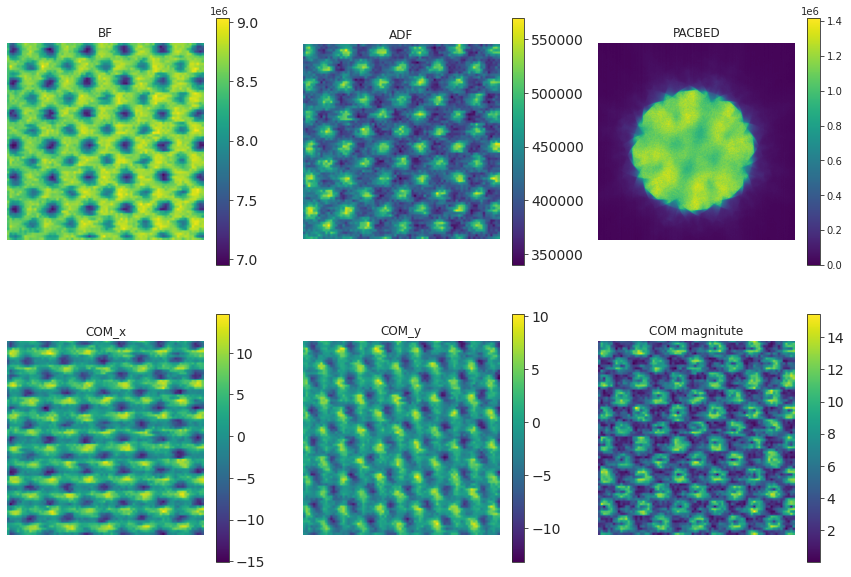

In [225]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(2,3,1)
plt.imshow(BF[1:81,:80], cmap = 'viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('BF')

fig.add_subplot(2,3,2)
plt.imshow(ADF[1:80:,:80], cmap = 'viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('ADF')

fig.add_subplot(2,3,3)
plt.imshow(PACBED[1:-1,1:-1], cmap = 'viridis')
cbar = plt.colorbar()
plt.axis('off')
plt.title('PACBED')

fig.add_subplot(2,3,4)
plt.imshow(COM_exp[1:80:,:80,0], cmap = 'viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_x')

fig.add_subplot(2,3,5)
plt.imshow(COM_exp[1:80:,:80,1], cmap = 'viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_y')

fig.add_subplot(2,3,6)
plt.imshow(COM_exp_mag[1:80:,:80], cmap = 'viridis')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.title('COM magnitute')

<IPython.core.display.Javascript object>


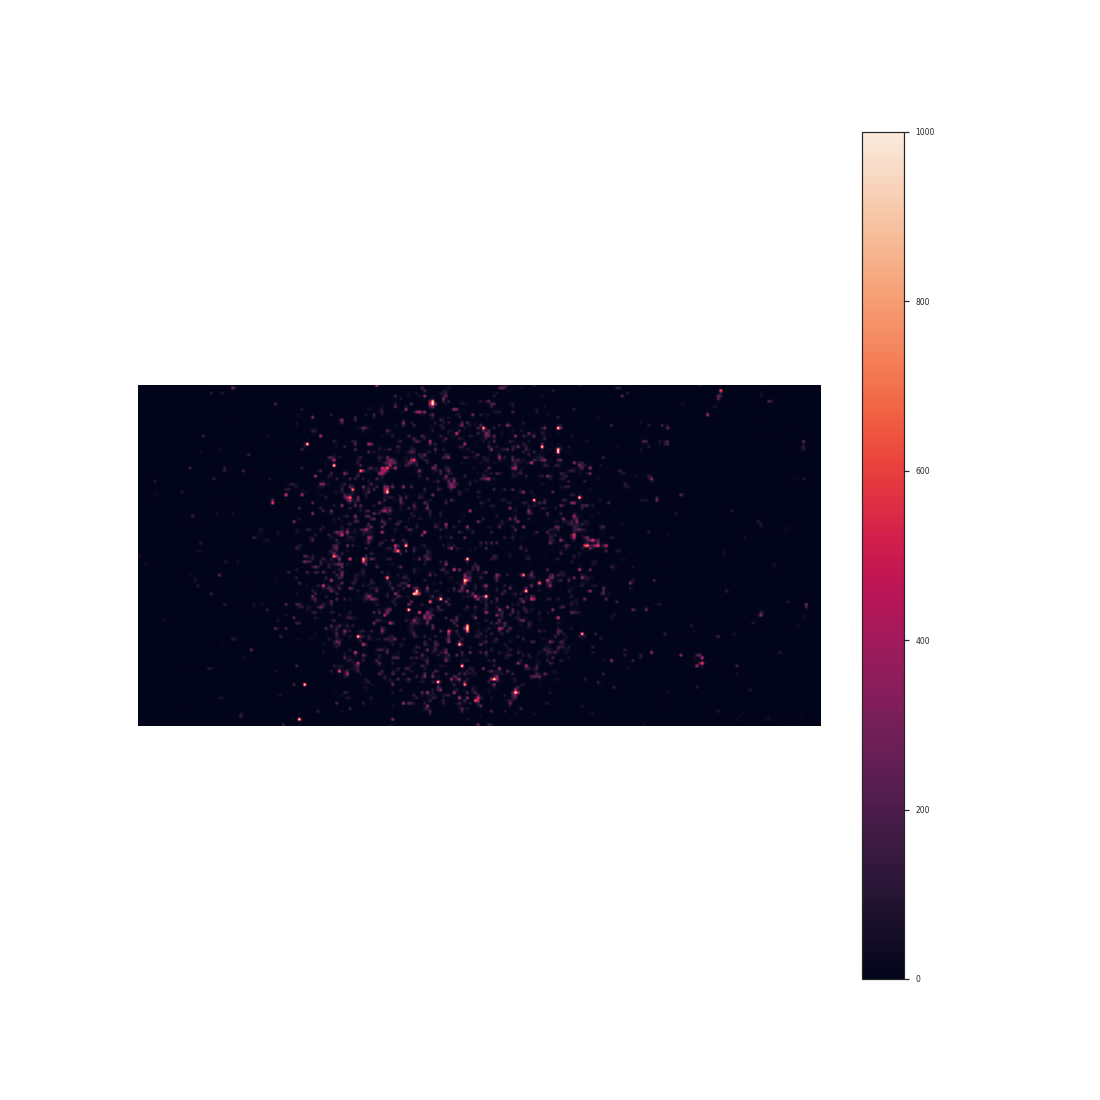

(-0.5, 255.5, 127.5, -0.5)

In [73]:
a = np.clip(expdata.data[1,1,:,:], 0, 1000)
fig = plt.figure(figsize=(10,10))
plt.imshow(a)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=5)
plt.axis('off')


In [69]:
%matplotlib notebook

<IPython.core.display.Javascript object>


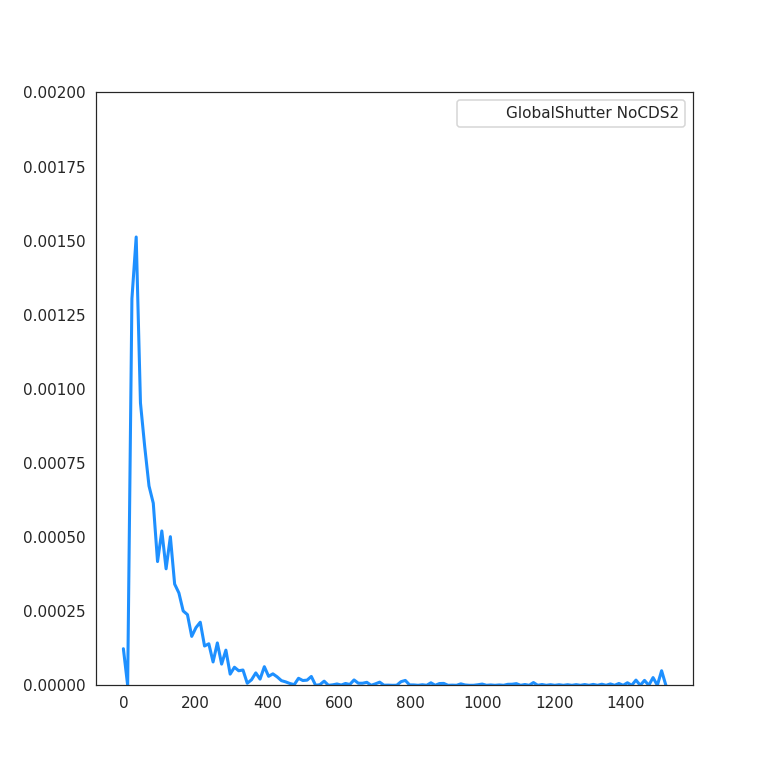

In [70]:
sample1 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210522/GSNoCDS2/npy/STO'+'_'+format(64,'05')+'.npy')
sample2 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210522/RSCDS2/npy/STO'+'_'+format(64,'05')+'.npy')
x1 = expdata.data[12,12,:,64:192].flatten()
#x1 = np.clip(x1, 0, 3000)
x2 = sample2.flatten()
import seaborn as sns
sns.set_style("white")

# Plot
kwargs = dict(hist_kws={'alpha':0}, kde_kws={'linewidth':2})

plt.figure(figsize = (7,7))
sns.distplot(x1, color="dodgerblue", label="GlobalShutter NoCDS2", **kwargs)
#sns.distplot([0], color="orange", label="RollingShutter CDS2", **kwargs)

plt.ylim(0,0.002)
plt.legend();

(-0.5, 511.5, 509.5, -0.5)

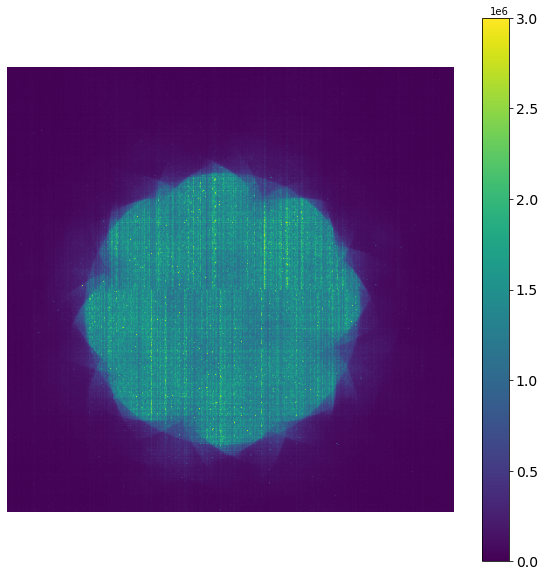

In [140]:
PACBED = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210522/GSNoCDS2/PACBED.npy')
a = np.clip(PACBED, 0, 3000000)
fig = plt.figure(figsize=(10,10))
plt.imshow(a[1:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')


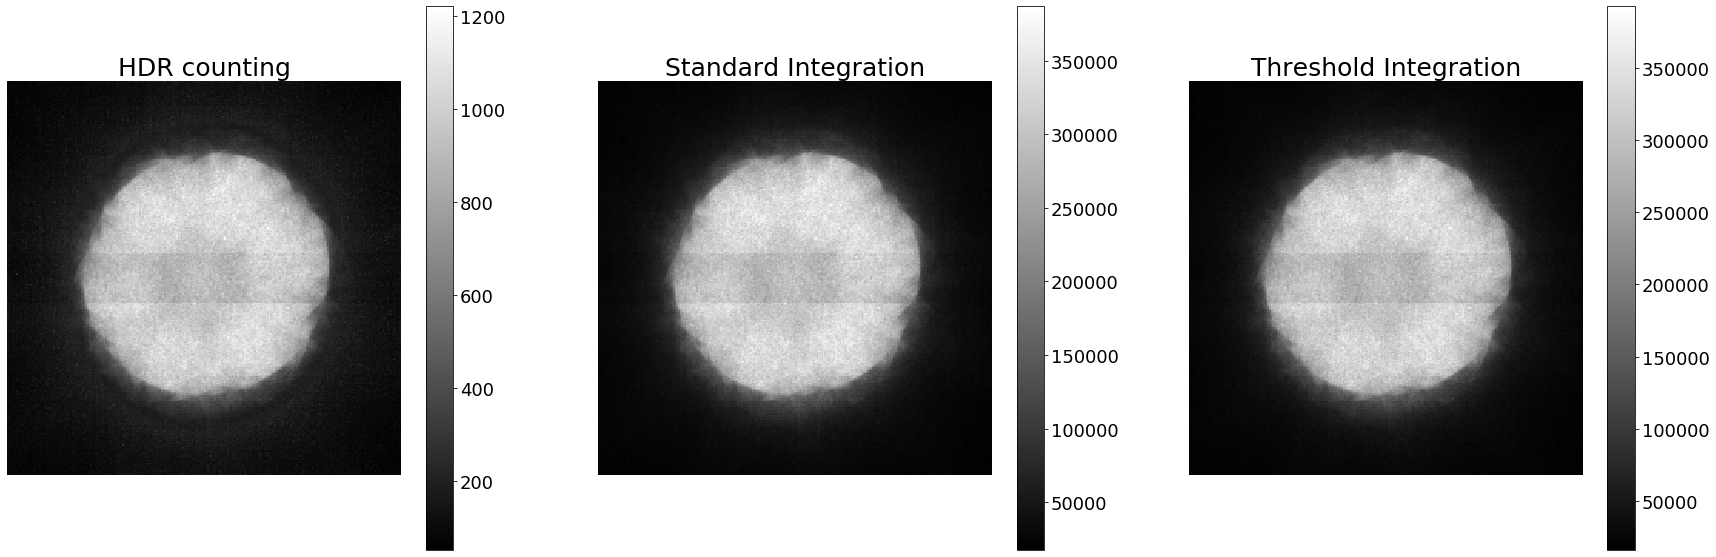

In [463]:
c1 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/counting/24000FPS/PACBED.npy')
c2 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/standard/24000FPS/PACBED.npy')
c3 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/threshold/24000FPS/PACBED.npy')

fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,3,1)
plt.imshow(c1)
plt.axis('off')
plt.title('HDR counting', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
fig.add_subplot(1,3,2)
plt.imshow(c2)
plt.axis('off')
plt.title('Standard Integration', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
fig.add_subplot(1,3,3)
plt.imshow(c3)
plt.axis('off')
plt.title('Threshold Integration', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)


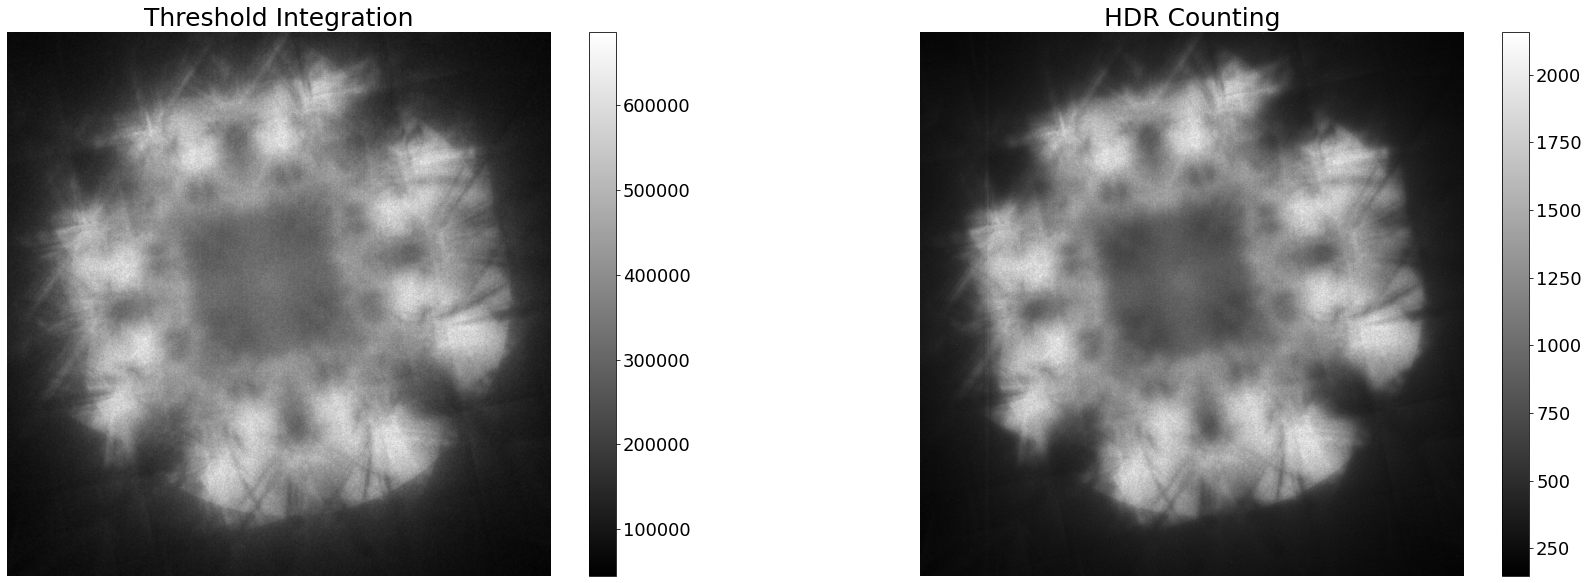

In [12]:
c1 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210319/threshold/PACBED.npy')[90:890,150:950]
c2 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210319/counting/PACBED.npy')[90:890,150:950]

fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,2,1)
plt.imshow(c1, cmap = 'gray')
plt.axis('off')
plt.title('Threshold Integration', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
fig.add_subplot(1,2,2)
plt.imshow(c2, cmap = 'gray')
plt.axis('off')
plt.title('HDR Counting', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)


In [11]:
c1.max()/c2.max()

318.04425158419247

In [250]:
print(c1.max(),c2.max(),c3.max())

print(c1.min(),c2.min(),c3.min())

print((c1.max()-c1.min())/c1.max(), (c2.max()-c2.min())/c2.max(),(c3.max()-c3.min())/c3.max())

390195.26916885376 387077.2751688957 392695.62629795074
16258.062931060791 17584.457677841187 16257.299737930298
0.9583335211477788 0.9545711959707052 0.9586007618898323


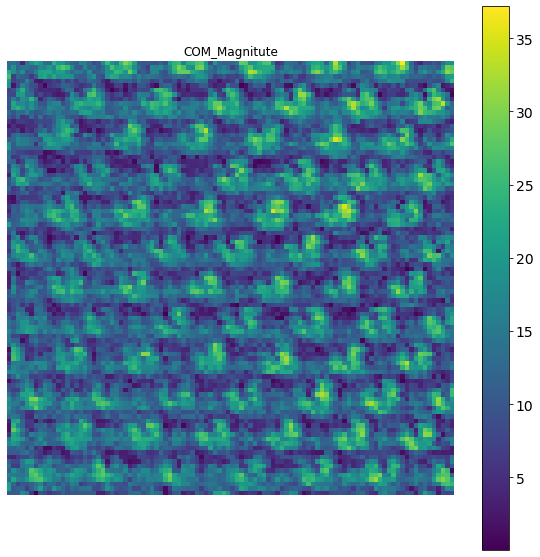

In [42]:
fig = plt.figure(figsize=(10,10))
COM_exp = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Results29M/COM.npy')
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)

plt.imshow(COM_exp_mag[2:-1,:])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')
plt.title('COM_Magnitute')
fig.savefig('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Results29M/COM_Magnitute.tif',dpi = 400,bbox_inches='tight')

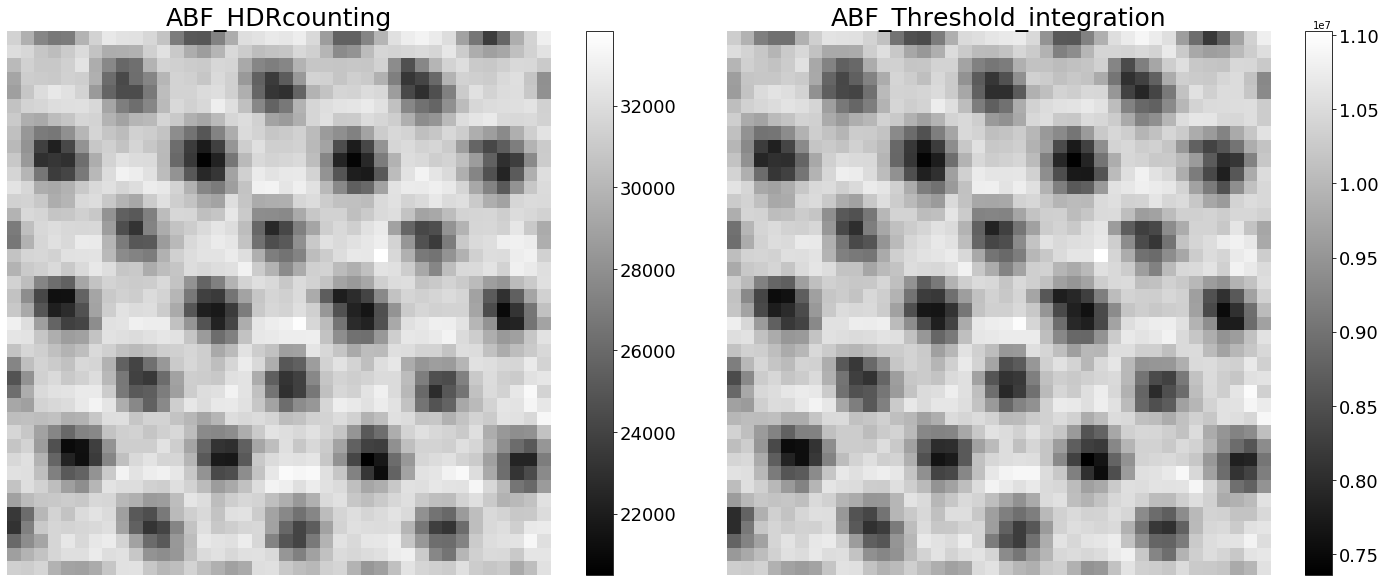

In [11]:
c1 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210319/counting/ABF.npy')
c2 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210319/threshold/ABF.npy')

fig = plt.figure(figsize=(20,8))
fig.add_subplot(1,2,1)
plt.imshow(c1[10:50,10:50])
plt.axis('off')
plt.title('ABF_HDRcounting', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
fig.add_subplot(1,2,2)
plt.imshow(c2[10:50,10:50])
plt.axis('off')
plt.title('ABF_Threshold_integration', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
fig.tight_layout()

"plt.axis('off')\nplt.plot((255,0),(111-16,111-16), linewidth = 1, c = 'b')\nplt.plot((255,0),(111,111), linewidth = 1, c = 'r')\nplt.plot((255,0),(143,143), linewidth = 1, c = 'r')\nplt.plot((255,0),(143+16,143+16), linewidth = 1, c = 'b')\nplt.plot((255,0),(111-2*16,111-2*16), linewidth = 1, c = 'y')\nplt.plot((255,0),(111-3*16,111-3*16), linewidth = 1, c = 'y')\nplt.plot((255,0),(111-4*16,111-4*16), linewidth = 1, c = 'y')\nplt.plot((255,0),(111-5*16,111-5*16), linewidth = 1, c = 'y')\nplt.plot((255,0),(111-6*16,111-6*16), linewidth = 1, c = 'y')"

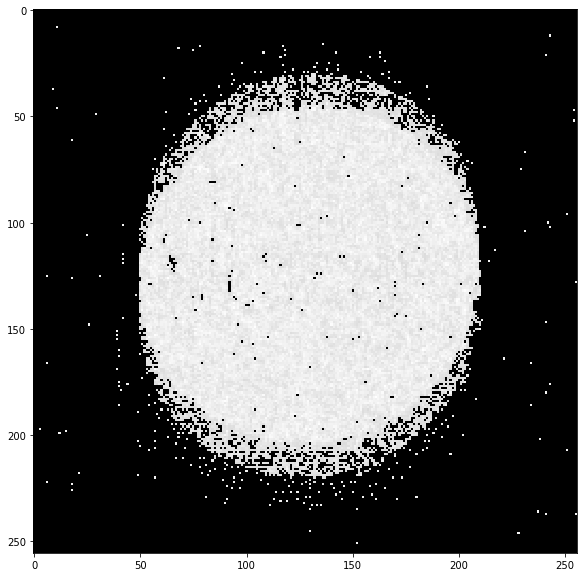

In [10]:
c1 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210405/counting/24000FPS/PACBED.npy')

fig = plt.figure(figsize=(30,10))

plt.imshow(log(expdata[10,:,:]+10e-17))
'''plt.axis('off')
plt.plot((255,0),(111-16,111-16), linewidth = 1, c = 'b')
plt.plot((255,0),(111,111), linewidth = 1, c = 'r')
plt.plot((255,0),(143,143), linewidth = 1, c = 'r')
plt.plot((255,0),(143+16,143+16), linewidth = 1, c = 'b')
plt.plot((255,0),(111-2*16,111-2*16), linewidth = 1, c = 'y')
plt.plot((255,0),(111-3*16,111-3*16), linewidth = 1, c = 'y')
plt.plot((255,0),(111-4*16,111-4*16), linewidth = 1, c = 'y')
plt.plot((255,0),(111-5*16,111-5*16), linewidth = 1, c = 'y')
plt.plot((255,0),(111-6*16,111-6*16), linewidth = 1, c = 'y')'''

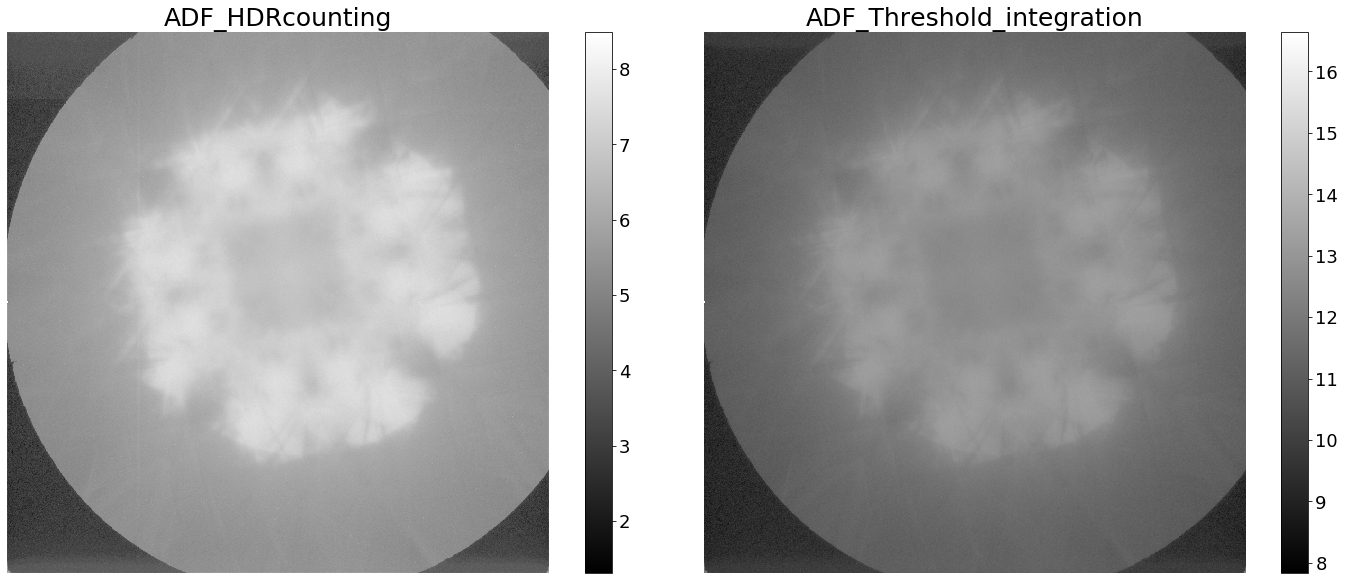

In [487]:
c1 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210319/counting/PACBED.npy')
c2 = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210319/threshold/PACBED.npy')

fig = plt.figure(figsize=(20,8))
fig.add_subplot(1,2,1)
plt.imshow(log(c1))
plt.axis('off')
plt.title('ADF_HDRcounting', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
fig.add_subplot(1,2,2)
plt.imshow(log(c2))
plt.axis('off')
plt.title('ADF_Threshold_integration', fontsize=25)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
fig.tight_layout()

## Symmetry STEM

In [3]:
import hyperspy.api as hs
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import skimage
import pyxem
from skimage.transform import rotate

In [4]:
def cross_corr(img):
    I_fft = np.fft.fft(img,axis=1)/720
    a = np.fft.ifft(I_fft*I_fft.conj()).real*720
    a = (np.mean(a,axis=0) - np.mean(img)**2)/(np.mean(img**2)- np.mean(img)**2)
    return a

def angulartotalcorr(self,selectk = False,kmin=0,kmax=0):
    if selectk is True:
        self_slice = self.isig[:,kmin:kmax]
        correlation = self_slice._map_iterate(cross_corr,inplace=False)
    else:
        correlation = self._map_iterate(cross_corr,inplace=False)
    correlation.axes_manager.navigation_axes = self.axes_manager.navigation_axes
    #correlation.set_axes(-1,name="Radians",scale=self.axes_manager[-2].scale,units="rad")
    return correlation

def corrsym(corr):
    #smap_2 = corr.isig[np.pi].data
    #smap_3 = (corr.isig[2*np.pi/3] + corr.isig[4*np.pi/3]).data/2
    #smap_4 = (corr.isig[np.pi/2] + corr.isig[3*np.pi/2]).data/2
    smap_4 = (corr.isig[90] + corr.isig[270]).data/2
    #smap_5 = (corr.isig[2*np.pi/5] + corr.isig[4*np.pi/5] + corr.isig[6*np.pi/5] + corr.isig[8*np.pi/5]).data/4
    #smap_6 = (corr.isig[np.pi/3] + corr.isig[5*np.pi/3]).data/2
    #smap_7 = (corr.isig[2*np.pi/7] + corr.isig[4*np.pi/7] + corr.isig[6*np.pi/7] + corr.isig[8*np.pi/7] + corr.isig[10*np.pi/7]+ corr.isig[12*np.pi/7]).data/6
    #smap_8 = (corr.isig[np.pi/4] + corr.isig[3*np.pi/4] + corr.isig[5*np.pi/4] + corr.isig[7*np.pi/4]).data/4
    #smap_9 = (corr.isig[2*np.pi/9] + corr.isig[4*np.pi/9] + corr.isig[6*np.pi/9] + corr.isig[8*np.pi/9] + corr.isig[10*np.pi/9]+ corr.isig[12*np.pi/9] + corr.isig[14*np.pi/9]+ corr.isig[16*np.pi/9]).data/8
    #smap_10 = (corr.isig[np.pi/5] + corr.isig[3*np.pi/5] + corr.isig[7*np.pi/5] + corr.isig[9*np.pi/5]).data/4
    return smap_4

In [5]:
ExpPath = '/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/29M/'
RefPath = '/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Blank/'
ExpName = '29M'
RefName = 'Blank'
rx = 100
ry = 100
kx = 1024
ky = 1024
Data_4D = np.zeros((100,100,1024,1024))
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
kx2,ky2 = np.meshgrid(kx,ky)
COM = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Results29M/BlankCOM_29M.npy')

# inner collection radius for ABF and outer collection radius for BF/ABF, replace with Hough detected radius later
ABF_radius = 162
BF_radius = 324
ADF_radius = 426

for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(ExpPath+ExpName+'_'+format(filenum,'05')+'.npy')
        #resized = cv2.resize(frame,(512,512),interpolation = cv2.INTER_AREA)
        Data_4D[ix,iy,:,:] = frame.astype('int')
        
        center_x = COM[ix,iy,0]
        center_y = COM[ix,iy,1]

        

Change array to signal2D format

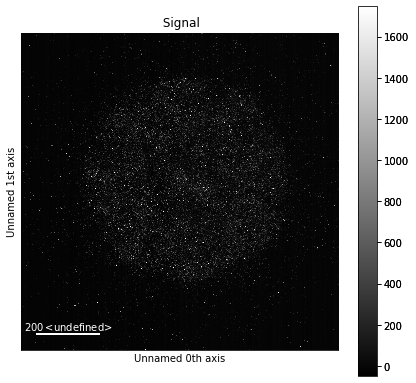

In [6]:
dc = hs.signals.Signal2D(Data_4D)

dc.inav[1,89].plot()
# Don't do this, takes toooooo long
#dc.save('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Results29M/Data4D.hdf5')


In [7]:
dc.axes_manager

<Axes manager, axes: (100, 100|1024, 1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |    100 |      0 |       0 |       1 | <undefined> 
     <undefined> |    100 |      0 |       0 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |   1024 |        |       0 |       1 | <undefined> 
     <undefined> |   1024 |        |       0 |       1 | <undefined>

Polar reprojection:

Make sure that the first amorphous ring is a line after the polar reprojection.) The center should correct.

In [11]:
dc.set_signal_type("electron_diffraction")
dc.beam_energy=200
dc.unit = "k_nm^-1"  # NO SET OF UNIT WILL GENERATE ERROR
rad = dc.get_azimuthal_integral2d(npt_rad=100, center=(471,535)) # cy axis[0] cx axis[1]
# tried 535,471 first


In [12]:
rad

<PolarDiffraction2D, title: , dimensions: (100, 100|360, 100)>

In [13]:
rad.sum()

<PolarDiffraction2D, title: , dimensions: (|360, 100)>

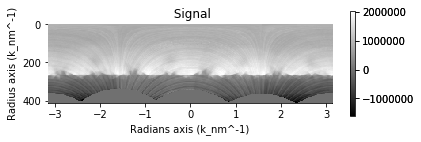

In [16]:
rad.sum().plot()

In [17]:
power = cor.get_angular_power()

NameError: name 'cor' is not defined

In [75]:
power

<Power2D, title: , dimensions: (100, 100|181, 100)>

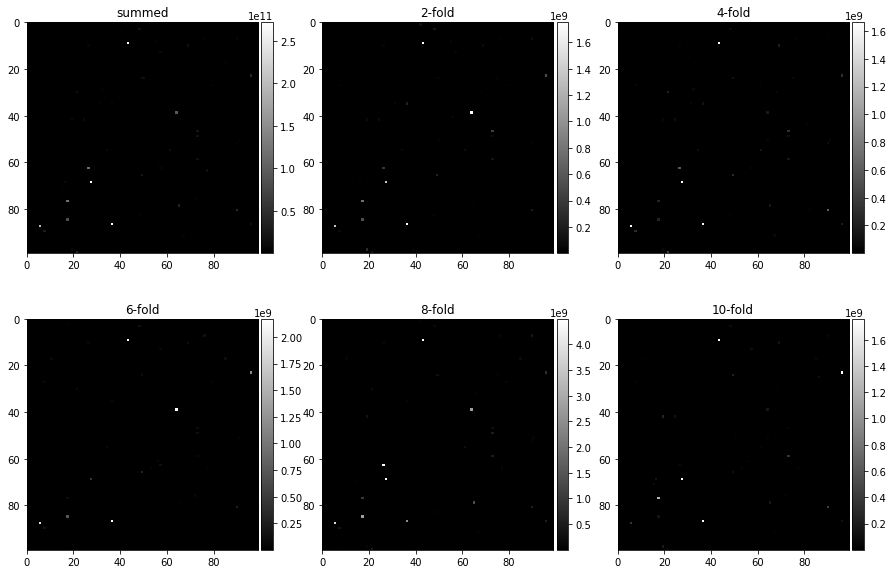

In [76]:
f = plt.figure(figsize=(15,10))
power.plot_symmetries(fig=f)

## Shuoyuan's code

In [18]:
corr = angulartotalcorr(rad,selectk=False)

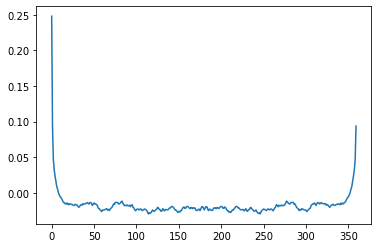

In [19]:
plt.plot(np.asarray(corr.inav[20,40]))

In [20]:
map1_4 = corrsym(corr)

In [21]:
map1_4.shape

(100, 100)

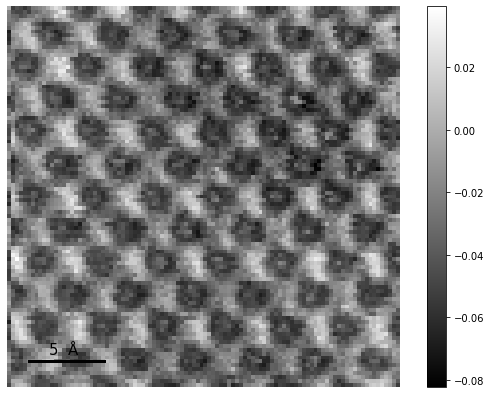

In [22]:
fig = plt.figure(figsize=(10,7))
mapping = np.transpose(map1_4)
plt.imshow(map1_4[2:-1,:],cmap = 'gray')
plt.plot([5,5+19.3],[90,90],linewidth=3, c = 'black')
plt.text(14,87,'5  \u212B', c = 'black',fontsize = 15,horizontalalignment='center',verticalalignment='center')
plt.axis('off')
plt.colorbar()
#fig.savefig('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Results29M/4FoldSymmetry.tif',dpi = 400,bbox_inches='tight')


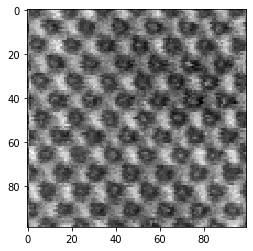

In [39]:
np.save('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Results29M/4FoldSymmetry.npy', map1_4[1:,:])
a = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210215/npy/Results29M/4FoldSymmetry.npy')
plt.imshow(a)

(-0.5, 99.5, 98.5, -0.5)

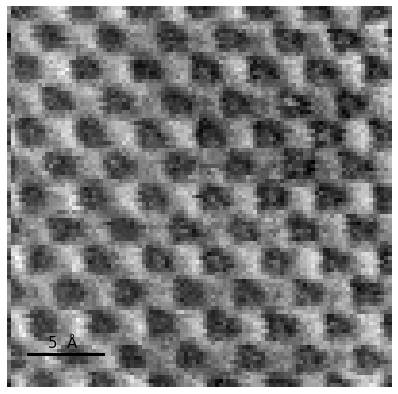

In [126]:
map1_2 = corr.isig[180].data
fig = plt.figure(figsize=(10,7))
plt.imshow(map1_2[1:,:],cmap = 'gray')
plt.plot([5,5+19.3],[90,90],linewidth=3, c = 'black')
plt.text(14,87,'5  \u212B', c = 'black',fontsize = 15,horizontalalignment='center',verticalalignment='center')
plt.axis('off')
